# Analysis of Real Estate Prices and Features in King County, Seattle 

![img](./images/kc_header.png)

(image courtesy of [beautifulwashington.com](https://beautifulwashington.com/king-county.html))

**Authors / Contributors:**

- Luke Dowker
- Jawwad Siddiqui
- Xiaohua Su

# Overview

**Recommendations:**

- null
- null
- null

# Business Problem

A real estate agency is looking to provide advice to homeowners looking to increase the values of their homes. We are seeking to identify several variables that can **predict** what a home's sale price can be.

**Alternately:** If a customer is looking to purchase land without a house already on the lot, our recommendations will help home builders maximize their profits by helping builders identify which predictor variables to focus on.

# Data investigation and cleaning

We kick things off by importing all necessary libraries and packages

In [1]:
# statsmodels
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import statsmodels.api as sm
from statsmodels.formula.api import ols
# sci-kit learn
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression
from sklearn.datasets import make_regression
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler
# baseline analysis and visualization
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# from random import gauss
# from mpl_toolkits.mplot3d import Axes3D

...and some formatting options.

In [2]:
# Shows *all* columns in dataframe, i.e. does not truncate horizontally
pd.set_option('display.max_columns', None)

# Converts from scientific notation to standard form (applied to every df in
# this notebook) and rounds to two decimal places
pd.set_option('display.float_format', lambda x: '%.2f' % x)

Below, we read in the data and check out some of its basic features: column names, null values, data types, etc.

In [3]:
# Reading in .csv file, creating initial pandas dataframe
df = pd.read_csv('data/kc_house_data.csv')

In [4]:
# Listing out column names
df.columns

Index(['id', 'date', 'price', 'bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade',
       'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode',
       'lat', 'long', 'sqft_living15', 'sqft_lot15'],
      dtype='object')

In [5]:
# Checking datatypes and null value counts
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21597 non-null  int64  
 1   date           21597 non-null  object 
 2   price          21597 non-null  float64
 3   bedrooms       21597 non-null  int64  
 4   bathrooms      21597 non-null  float64
 5   sqft_living    21597 non-null  int64  
 6   sqft_lot       21597 non-null  int64  
 7   floors         21597 non-null  float64
 8   waterfront     19221 non-null  object 
 9   view           21534 non-null  object 
 10  condition      21597 non-null  object 
 11  grade          21597 non-null  object 
 12  sqft_above     21597 non-null  int64  
 13  sqft_basement  21597 non-null  object 
 14  yr_built       21597 non-null  int64  
 15  yr_renovated   17755 non-null  float64
 16  zipcode        21597 non-null  int64  
 17  lat            21597 non-null  float64
 18  long  

**Two components** of this `info` printout that we can immediately identify as problems we may need to address:

1. Columns currently coded as datatype `object`...

    - `date`
    - `waterfront`
    - `view`
    - `condition`
    - `grade`
    - `sqft_basement`


2. Columns currently containing null values...

    - `waterfront`
    - `view`
    - `yr_renovated`

In [6]:
# Descriptive statistics for numerical columns
df.describe()

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,sqft_above,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
count,21597.00,21597.00,21597.00,21597.00,21597.00,21597.00,21597.00,21597.00,21597.00,17755.00,21597.00,21597.00,21597.00,21597.00,21597.00
mean,4580474287.77,540296.57,3.37,2.12,2080.32,15099.41,1.49,1788.60,1971.00,83.64,98077.95,47.56,-122.21,1986.62,12758.28
std,2876735715.75,367368.14,0.93,0.77,918.11,41412.64,0.54,827.76,29.38,399.95,53.51,0.14,0.14,685.23,27274.44
min,1000102.00,78000.00,1.00,0.50,370.00,520.00,1.00,370.00,1900.00,0.00,98001.00,47.16,-122.52,399.00,651.00
25%,2123049175.00,322000.00,3.00,1.75,1430.00,5040.00,1.00,1190.00,1951.00,0.00,98033.00,47.47,-122.33,1490.00,5100.00
50%,3904930410.00,450000.00,3.00,2.25,1910.00,7618.00,1.50,1560.00,1975.00,0.00,98065.00,47.57,-122.23,1840.00,7620.00
75%,7308900490.00,645000.00,4.00,2.50,2550.00,10685.00,2.00,2210.00,1997.00,0.00,98118.00,47.68,-122.12,2360.00,10083.00
max,9900000190.00,7700000.00,33.00,8.00,13540.00,1651359.00,3.50,9410.00,2015.00,2015.00,98199.00,47.78,-121.31,6210.00,871200.00


Looking at the row of `max` values, we can see right away that we have some outliers, values that look as if they depart substantially from the `75%` row; to be more specific, there are some **large, expensive** properties in this dataset.

There's also one property listed with **33 bedrooms** - what's up with that?

In [7]:
df.loc[(df['bedrooms']) == 33]

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
15856,2402100895,6/25/2014,640000.00,33,1.75,1620,6000,1.00,NO,NONE,Very Good,7 Average,1040,580.0,1947,0.00,98103,47.69,-122.33,1330,4700


## Basic data cleaning

First, we convert the column `date` to a more usable format; the code below transforms the column to type `datetime64[ns]`.

In [8]:
# Converting column `date` to datetime64[ns] from type string/object
df['date'] = df['date'].astype('datetime64[ns]')

Likewise, the column `grade` is in object format; it provides both a number and a corresponding descriptor, e.g. `5 Fair`. The following code transforms it to a more usable format, one with no whitespace.

In [9]:
# Clean up the values in column `grade` so they are not
# separated by whitespace
df['grade'] = [x.replace(" ", "_").strip() for x in df['grade']]

In [10]:
# Validating that above code worked as intended
df['grade'].value_counts()

7_Average        8974
8_Good           6065
9_Better         2615
6_Low_Average    2038
10_Very_Good     1134
11_Excellent      399
5_Fair            242
12_Luxury          89
4_Low              27
13_Mansion         13
3_Poor              1
Name: grade, dtype: int64

Every house has a unique `id` value, but does every row in the dataset represent a **unique house?**

In [11]:
# Check for multiples in column `id`
df['id'].value_counts()

795000620     3
1825069031    2
2019200220    2
7129304540    2
1781500435    2
             ..
7812801125    1
4364700875    1
3021059276    1
880000205     1
1777500160    1
Name: id, Length: 21420, dtype: int64

Looks like we have a few houses with more than one sale on record! Let's examine a few of the `id` values.

In [12]:
df.loc[(df['id'] == 795000620) |
       (df['id'] == 1825069031) |
       (df['id'] == 2019200220)]

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
3946,1825069031,2014-08-14,550000.00,4,1.75,2410,8447,2.00,NO,GOOD,Good,8_Good,2060,350.0,1936,1980.00,98074,47.65,-122.09,2520,14789
3947,1825069031,2014-10-16,550000.00,4,1.75,2410,8447,2.00,NaN,GOOD,Good,8_Good,2060,350.0,1936,1980.00,98074,47.65,-122.09,2520,14789
12942,2019200220,2014-09-23,160000.00,3,2.25,1470,8682,1.00,NO,NONE,Average,7_Average,1160,310.0,1985,0.00,98003,47.27,-122.30,1670,8359
12943,2019200220,2015-02-26,269000.00,3,2.25,1470,8682,1.00,NO,NONE,Average,7_Average,1160,310.0,1985,nan,98003,47.27,-122.30,1670,8359
17588,795000620,2014-09-24,115000.00,3,1.00,1080,6250,1.00,NO,NONE,Fair,5_Fair,1080,0.0,1950,0.00,98168,47.50,-122.33,1070,6250
17589,795000620,2014-12-15,124000.00,3,1.00,1080,6250,1.00,NO,NONE,Fair,5_Fair,1080,0.0,1950,0.00,98168,47.50,-122.33,1070,6250
17590,795000620,2015-03-11,157000.00,3,1.00,1080,6250,1.00,NaN,NONE,Fair,5_Fair,1080,0.0,1950,nan,98168,47.50,-122.33,1070,6250


The house with the `id` value `1825069031` saw no change in its sale price between its first sale (in August 2014) and second sale (in October 2014). However, the *other* two houses we're looking at here - `	2019200220` and `795000620` - saw their sale prices **increase** over time, and with no changes in any other column!

It might be best to keep the **most recent** sale on record to avoid adding any additional 'noise' to our model.

In [13]:
# Dropping rows with duplicate values in `id` column,
# sans the most recent sale
df.drop_duplicates(subset=['id'], keep='last', inplace=True)

Let's make sure that worked...

In [14]:
# Ensuring that number of unique `id` values matches
# number of rows in dataframe, i.e. no repeated values
len(df['id'].unique()) == len(df)

True

In [15]:
# Ensuring that only one sale remains for a house
# we know initially had multiple sales on record
df.loc[ df['id'] == 795000620 ]['date']

17590   2015-03-11
Name: date, dtype: datetime64[ns]

We only got one result when indexing into the `date` column for the property `795000620`, and it's the date of the most recent sale on record for `795000620`! We've eliminated *all but the most recent sale* for any property with more than one sale on record.

We no longer have any use for the `id` column, so we can drop it from our dataframe entirely.

In [16]:
print(df['date'].min())
print(df['date'].max())

2014-05-02 00:00:00
2015-05-27 00:00:00


In [17]:
# Dropping `id` column, now that we know we
# have exclusively unique values for `id`

df.drop(labels='id',
        axis=1,
        inplace=True)

**Something else that might be of note:** in some of these rows where the same `id` appears twice, a value that *was* recorded in the first sale appears as a *null value* in a later sale, e.g. the `waterfront` column on the house whose `id` is `1825069031`.

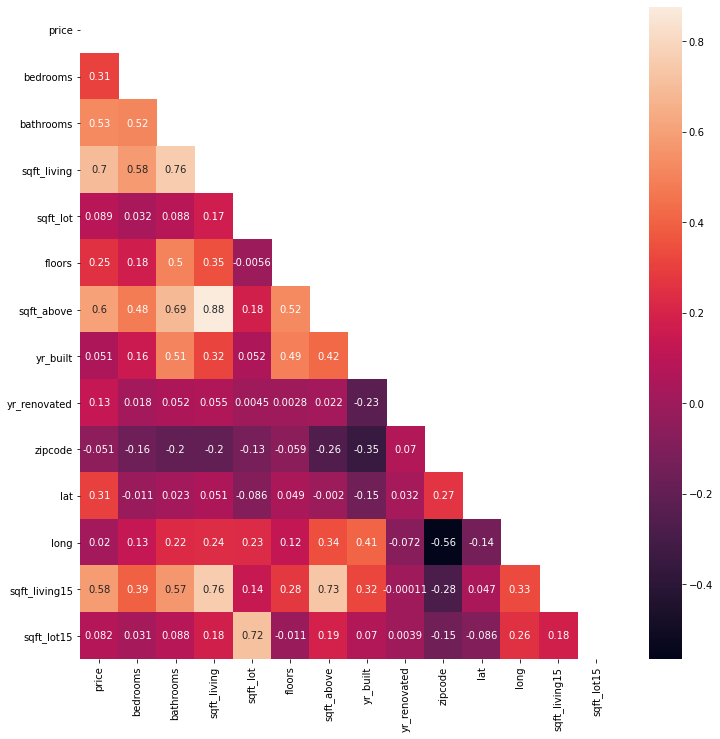

In [114]:
# Visualizing correlations between numerical columns
# with a seaborn heatmap to investigate the correlation
# of various features w/ `price` and assess potential
# issues with multicollinearity

fig, ax = plt.subplots(figsize=(12, 12))
corr = df.corr()

# Instantiate numpy array of zeroes and assign to `mask`
mask = np.zeros_like(corr,
                     dtype=bool)

# Returns indices from upper triangle of array
mask[np.triu_indices_from(mask)] = True

sns.heatmap(corr,
            annot=True,
            mask=mask);

**Observations from this heatmap:**

- `sqft_living` has the highest correlation with price, an r-value of `0.7`...
    - ...but `sqft_living` is also correlated with several other columns: `bedrooms`, `bathrooms`, `sqft_above` (this one has an r-value of `0.88`!), and `sqft_living15`, so we'll need to be careful that we don't include collinear features in our models.
- `zipcode`, `lat`, and `long` all have low (`0.31` or below) correlations with `price` - these columns likely won't be useful to us in constructing models for this project, but could be worth looking into as next-step recommendations.

In [19]:
# Creating copy of original dataframe before dropping columns
df_copy = df.copy()

In [20]:
# Drop irrelevant columns
df_copy.drop(columns=['date',
                      'floors',
                      'waterfront',
                      'condition',
                      'sqft_above',  # potential for multicollinearity
                      'sqft_basement',  # potential for multicollinearity
                      'yr_renovated',
                      'lat',
                      'long',
                      'sqft_living15',  # potential for multicollinearity
                      'sqft_lot15'],
             inplace=True)

In [21]:
# mms = MinMaxScaler()
# df_copy[['bathrooms']] = mms.fit_transform(df_copy[['bathrooms']])

In [22]:
df_copy.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21420 entries, 0 to 21596
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   price        21420 non-null  float64
 1   bedrooms     21420 non-null  int64  
 2   bathrooms    21420 non-null  float64
 3   sqft_living  21420 non-null  int64  
 4   sqft_lot     21420 non-null  int64  
 5   view         21357 non-null  object 
 6   grade        21420 non-null  object 
 7   yr_built     21420 non-null  int64  
 8   zipcode      21420 non-null  int64  
dtypes: float64(2), int64(5), object(2)
memory usage: 1.6+ MB


We've got some nulls in the `view` column, but the number of null values *vis-à-vis*  the number of total rows in the dataframe is such that we can safely drop those nulls without worrying about our conclusions being affected.

In [23]:
# Dropping nulls from column `view`
df_copy = df_copy.dropna(subset = ['view'])

In [24]:
# Validating that...
df_copy['view'].isna().sum() == 0

True

`view` and `grade` might seem similar on first glance - both columns use descriptors like `AVERAGE` and `GOOD` to assess the attributes of a house - but we determined that `grade` is a much more mutable category; it refers to the "types of materials used (in building the house) and the quality of workmanship" on display in the house's "construction and design."

Let's get a breakdown of the distribution of `grade` values in King County.

In [25]:
# Checking out the frequency of each possible value
# for column `grade`
df_copy['grade'].value_counts()

7_Average        8863
8_Good           6029
9_Better         2595
6_Low_Average    1988
10_Very_Good     1126
11_Excellent      394
5_Fair            234
12_Luxury          87
4_Low              27
13_Mansion         13
3_Poor              1
Name: grade, dtype: int64

We find only **one row** where the `grade` value is equal to `3 Poor`. We drop this column to eliminate an outlier.

In [26]:
# Dropping the single row where `grade` is equal to
# `3 Poor`, in order to eliminate an outlier
df_copy = df_copy[df_copy['grade'] != '3 Poor']

In [27]:
df_copy.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21357 entries, 0 to 21596
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   price        21357 non-null  float64
 1   bedrooms     21357 non-null  int64  
 2   bathrooms    21357 non-null  float64
 3   sqft_living  21357 non-null  int64  
 4   sqft_lot     21357 non-null  int64  
 5   view         21357 non-null  object 
 6   grade        21357 non-null  object 
 7   yr_built     21357 non-null  int64  
 8   zipcode      21357 non-null  int64  
dtypes: float64(2), int64(5), object(2)
memory usage: 1.6+ MB


All set to begin preprocessing!

In [28]:
# df_copy['sqft_living'] = np.log(df_copy['sqft_living'])

# Splitting data into train and test sets

Our **target** variable, or `X`, is going to be `price`, i.e. the sale price of a given home.

In [29]:
# Creating target variable and predictor dataframe
y = df_copy['price']
X = df_copy.drop(labels='price',
                 axis=1)

In [30]:
y2 = y
X2 = X['sqft_living']

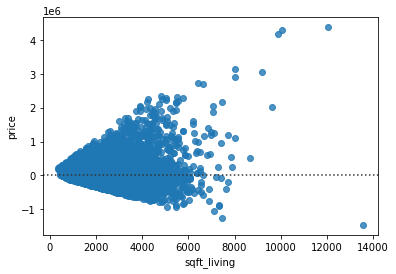

In [31]:
# Viewing residuals of sqft_living vs. price
sns.residplot(x=X2, y=y2);

In [32]:
# Initiating train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=42)

In [33]:
# Check out `X_train`
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14309 entries, 1215 to 15996
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   bedrooms     14309 non-null  int64  
 1   bathrooms    14309 non-null  float64
 2   sqft_living  14309 non-null  int64  
 3   sqft_lot     14309 non-null  int64  
 4   view         14309 non-null  object 
 5   grade        14309 non-null  object 
 6   yr_built     14309 non-null  int64  
 7   zipcode      14309 non-null  int64  
dtypes: float64(1), int64(5), object(2)
memory usage: 1006.1+ KB


In [34]:
X_train.shape[0] == y_train.shape[0]

True

In [35]:
X_test.shape[0] == y_test.shape[0]

True

In [36]:
# Creating concatenated dataframes
train_df = pd.concat([X_train, y_train], axis=1)
test_df = pd.concat([X_test, y_test], axis=1)

In [37]:
train_df.head();

In [38]:
test_df.head();

Below, we group the dataset by column `view` and get some descriptive statistics on the column.

In [39]:
# df_copy.groupby('view').mean()
# df_copy.sort_values('price', ascending = False).head()

In [40]:
# fig, ax = plt.subplots(figsize=(20,10))

# sns.histplot(df_copy['grade'])

In [41]:
# fig, ax = plt.subplots(figsize=(8,8))
# heat = sns.heatmap(train_df.corr(), annot = True)

## Baseline Model (using DummyRegressor)

In [102]:
# Instantiate the DummyRegressor
dummy_lr = DummyRegressor(strategy='median')

# Create variables
X_dummy = train_df['sqft_living']
y_dummy = train_df['price']

# Fit regressor to variables
dummy_lr.fit(X_dummy, y_dummy)

# Score
print(f"R-squared value for baseline model: {dummy_lr.score(X_dummy, y_dummy)}")

R-squared value for baseline model: -0.06112257753463668


In [112]:
dummy_lr.predict(X_train)

array([452000., 452000., 452000., ..., 452000., 452000., 452000.])

In [44]:
# What else CAN we do with the dummy regressor?
# What else do we still NEED to do?

## Initial Model

In [45]:
# Using statsmodel.OLS to create our first model,
# with a single feature (sqft_living)
simple_model = sm.OLS(y_train, sm.add_constant(X_train['sqft_living'])).fit()

In [46]:
simple_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.485
Model:                            OLS   Adj. R-squared:                  0.485
Method:                 Least Squares   F-statistic:                 1.346e+04
Date:                Wed, 30 Mar 2022   Prob (F-statistic):               0.00
Time:                        16:23:11   Log-Likelihood:            -1.9882e+05
No. Observations:               14309   AIC:                         3.976e+05
Df Residuals:                   14307   BIC:                         3.977e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const        -3.57e+04   5440.380     -6.563      0.000   -4.64e+04    -2.5e+04
sqft_living   277.2205      2.389    116.035      0.000     272.538     281.904
==============================================================================
Omnibus:                     9226.498   Durbin-Watson:                   2.002
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           257916.983
Skew:                           2.659   Prob(JB):                         0.00
Kurtosis:                      23.107   Cond. No.                     5.66e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.66e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [47]:
# Grabbing predictions from simple linear model
simple_train_preds = simple_model.predict(sm.add_constant(X_train['sqft_living']))

simple_train_preds[:5]

1215    1103672.90
12590    468837.86
13720    291416.71
15200    260922.45
10730    729425.17
dtype: float64

In [48]:
# First round of residuals
resids = y_train - simple_train_preds

resids[:5]

1215     776327.10
12590   -241347.86
13720     47483.29
15200    -85922.45
10730     15574.83
dtype: float64

In [113]:
mean_squared_error(y_true=y_train,
                   y_pred=simple_train_preds,
                   squared=False)

261866.1740107072

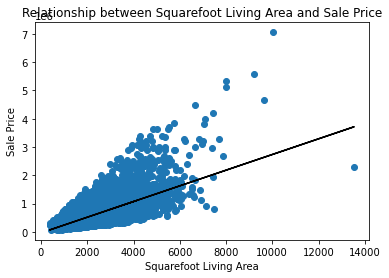

In [50]:
# Just looking at two variables

# Plot our points, rating vs balance, as a scatterplot
plt.scatter(train_df['sqft_living'], train_df['price'])

# Plot the line of best fit!
plt.plot(train_df['sqft_living'], simple_train_preds, color='black')

plt.ylabel('Sale Price')
plt.xlabel('Squarefoot Living Area')
plt.title('Relationship between Squarefoot Living Area and Sale Price')
plt.show()

### `view` Analysis

is there a difference between those that have a view versus those that don't

In [51]:
summary_of_view = df_copy.groupby('view').agg(['mean', 'std'])

summary_of_view

price           bedrooms      bathrooms      sqft_living  \
                mean       std     mean  std      mean  std        mean   
view                                                                      
AVERAGE    791956.68 510351.93     3.57 0.98      2.43 0.87     2651.20   
EXCELLENT 1454416.19 934214.96     3.63 1.10      2.78 1.07     3337.17   
FAIR       814386.56 513226.70     3.53 0.98      2.35 0.84     2573.51   
GOOD       972849.27 615076.79     3.67 0.93      2.67 0.89     3012.47   
NONE       498336.32 287341.26     3.35 0.92      2.07 0.74     2001.17   

                  sqft_lot           yr_built        zipcode        
              std     mean       std     mean   std     mean   std  
view                                                                
AVERAGE   1133.59 22331.72  60261.29  1964.82 29.70 98090.98 59.82  
EXCELLENT 1544.93 21762.46  35989.90  1965.77 27.23 98096.41 61.65  
FAIR      1042.89 12342.66  17078.17  1962.90 26.36 98096.60 61.08  
GOOD      1204.88 35010.67 109236.86  1967.34 30.00 98092.44 62.24  
NONE       837.19 14178.46  37109.10  1971.73 29.37 98076.21 52.33

Observations from this summary:

- Significant gap between `EXCELLENT` and `GOOD`
- Smallest gap is between `FAIR` and `AVERAGE` - we'll need to determine if this difference is a signficant one.

From the df summary, we notice that there is a difference in price between price for those that are excellent
compared to those that have a view written as none. Further investigation will be performed to determine if this
difference is statistically significant

In [52]:
# Figure out how to do this in a loop/function?
df_average = train_df[train_df['view'] == 'AVERAGE']
df_excellent = train_df[train_df['view'] == 'EXCELLENT']
df_fair = train_df[train_df['view'] == 'FAIR']
df_good = train_df[train_df['view'] == 'GOOD']
df_none = train_df[train_df['view'] == 'NONE']

In [53]:
train_df['view'].value_counts()

NONE         12899
AVERAGE        644
GOOD           336
FAIR           225
EXCELLENT      205
Name: view, dtype: int64

Subsetting the data into different views
 - Number of rows:
     - `NONE` = 12906
     - `AVERAGE` = 636
     - `GOOD` = 342
     - `FAIR` = 213
     - `EXCELLENT` = 212

In [54]:
fvalue, pvalue = stats.f_oneway(df_average['price'], df_excellent['price'], df_fair['price'],
                                df_good['price'] , df_none['price'])

In [55]:
#creating df of just view
# df_view = train_df[['view', 'price']]

#Tukey test
#print(pairwise_tukeyhsd(df_view['price'], df_view['view']))

`AVERAGE` and `FAIR` are not significant to each other, so they should be grouped together. Each other subset should be on their own as they have a p value of < .05

#### Grade Analysis

 Is there a difference between grades

In [56]:
train_df.grade.value_counts()

7_Average        5961
8_Good           4061
9_Better         1722
6_Low_Average    1299
10_Very_Good      769
11_Excellent      269
5_Fair            144
12_Luxury          61
4_Low              18
13_Mansion          5
Name: grade, dtype: int64

In [57]:
# Dropping poor row, since there is only one
df3 = train_df.copy()
df3 = df3[df3['grade'] != '3 Poor']

In [58]:
df3.grade = [x.replace(" ", "_").strip() for x in df3.grade]

In [59]:
df3['grade'].value_counts()

7_Average        5961
8_Good           4061
9_Better         1722
6_Low_Average    1299
10_Very_Good      769
11_Excellent      269
5_Fair            144
12_Luxury          61
4_Low              18
13_Mansion          5
Name: grade, dtype: int64

In [60]:
# Might need a for loop or a function here
df_10 = train_df[train_df['grade'] == '10 Very Good']
df_11 = train_df[train_df['grade'] == '11 Excellent']
df_12 = train_df[train_df['grade'] == '12 Luxury']
df_4 = train_df[train_df['grade'] == '4 Low']
df_5 = train_df[train_df['grade'] == '5 Fair']
df_6 = train_df[train_df['grade'] == '6 Low Average']
df_7 = train_df[train_df['grade'] == '7 Average']
df_8 = train_df[train_df['grade'] == '8 Good']
df_9 = train_df[train_df['grade'] == '9 Better']

In [61]:
# Finding f-statistic and p-value using ANOVA testing

f_value_grade, p_value_grade = stats.f_oneway(df_10['price'], df_11['price'], df_12['price'],
                                              df_4['price'], df_5['price'], df_6['price'],
                                              df_7['price'], df_8['price'], df_9['price'])
p_value_grade

C:\Users\toast\anaconda3\envs\learn-env\lib\site-packages\scipy\stats\stats.py:3612: F_onewayBadInputSizesWarning: at least one input has length 0
  warnings.warn(F_onewayBadInputSizesWarning('at least one input '


nan

This 0.0 value indicates there is significance **somewhere** between `grade` values, but additional testing is required to determine **where** exactly this significance exists.

There is a significant difference in price betweeen grades but we don't know which one is significant.
Further testing required to determine which is important

In [62]:
# Ad-hoc test to determine differeces in price vs. grade

df_grade = train_df[['grade', 'price']]

print(pairwise_tukeyhsd(df_grade['price'], df_grade['grade']))

                Multiple Comparison of Means - Tukey HSD, FWER=0.05                
    group1        group2       meandiff   p-adj      lower         upper     reject
-----------------------------------------------------------------------------------
 10_Very_Good  11_Excellent   432862.5842  0.001   375726.8067   489998.3618   True
 10_Very_Good     12_Luxury  1223043.1185  0.001  1115752.9978  1330333.2392   True
 10_Very_Good    13_Mansion  2353715.2497  0.001   1991829.832  2715600.6674   True
 10_Very_Good         4_Low  -879781.9725  0.001 -1072107.4055  -687456.5395   True
 10_Very_Good        5_Fair  -808571.6948  0.001  -881810.2466   -735333.143   True
 10_Very_Good 6_Low_Average  -760126.9251  0.001  -796826.0997  -723427.7505   True
 10_Very_Good     7_Average  -657980.9773  0.001  -688886.3209  -627075.6337   True
 10_Very_Good        8_Good  -519509.1955  0.001  -551229.8892  -487788.5019   True
 10_Very_Good      9_Better  -286349.5018  0.001  -321332.4088  -251366.5948

Summary of what we notice

#### One Hot Encoding | Rework to include Train only

In [63]:
#categorizing average and fair together since they are not different from each other
df3['view'] = df3['view'].str.replace('AVERAGE', 'FAIR')

In [64]:
#making the categorical variable
cate_column = df3[['grade', 'view']]

cate_column

,grade,view
1215,9_Better,GOOD
12590,7_Average,NONE
13720,7_Average,NONE
15200,7_Average,NONE
10730,9_Better,NONE
...,...,...
11423,8_Good,NONE
12112,7_Average,NONE
5451,8_Good,NONE
874,10_Very_Good,NONE


In [65]:
ohe = OneHotEncoder(drop='first')

column_name = ['grade', 'view']
features = cate_column.copy()

features2 = features[column_name]

cate_ohe = ohe.fit_transform(features2)

cate_ohe

<14309x12 sparse matrix of type '<class 'numpy.float64'>'
	with 27644 stored elements in Compressed Sparse Row format>

In [66]:
name = ohe.get_feature_names_out()

In [67]:
cate_parsed = pd.DataFrame(cate_ohe.todense(), columns = name, index = features.index)
cate_parsed

,grade_11_Excellent,grade_12_Luxury,grade_13_Mansion,grade_4_Low,grade_5_Fair,grade_6_Low_Average,grade_7_Average,grade_8_Good,grade_9_Better,view_FAIR,view_GOOD,view_NONE
1215,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,1.00,0.00
12590,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,1.00
13720,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,1.00
15200,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,1.00
10730,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,1.00
...,...,...,...,...,...,...,...,...,...,...,...,...
11423,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00
12112,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,1.00
5451,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00
874,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00


### Scaling | Rework only to include train

In [68]:
# Creating dataframe with only numerical columns
numbers = train_df.select_dtypes(np.number)

In [69]:
#Rework to include only the train_df
ss = StandardScaler()

columns_name1 = ['price', 'sqft_living']
numbers_scaling = numbers.copy()

features= numbers_scaling[columns_name1]

scale1 = ss.fit(features)
scale2 = scale1.transform(features)
numbers_scaling[columns_name1] = scale2

numbers_scaling

,bedrooms,bathrooms,sqft_living,sqft_lot,yr_built,zipcode,price
1215,5,3.25,2.21,7920,1921,98122,3.67
12590,3,1.75,-0.29,7194,1967,98003,-0.86
13720,3,1.75,-0.99,4000,1929,98118,-0.56
15200,3,1.00,-1.11,6164,1967,98001,-1.01
10730,4,2.50,0.74,13093,1989,98075,0.56
...,...,...,...,...,...,...,...
11423,3,2.50,0.04,2374,2005,98052,-0.20
12112,3,1.75,-0.05,273556,1997,98070,-0.20
5451,4,3.00,1.40,100681,1977,98058,0.67
874,3,2.25,1.06,12095,1983,98006,0.87


In [70]:
#combinig scale and ohe
scaled_and_parse_df = pd.concat([numbers_scaling, cate_parsed], axis = 1)

In [71]:
scaled_and_parse_df.columns = [x.replace(" ", "_").strip() for x in scaled_and_parse_df.columns]

## Linear Regression | Rework so fit is only on train and not test

#### simple linear

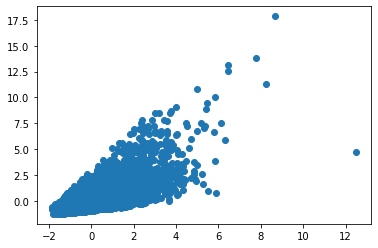

In [72]:
fig, ax = plt.subplots()

x = scaled_and_parse_df['sqft_living']
y = scaled_and_parse_df['price']


ax.scatter(x, y);

In [73]:
np.corrcoef(df['sqft_living'],df['price'])

array([[1.        , 0.70129486],
       [0.70129486, 1.        ]])

Passing our first assumption: Based on our scatterplot, we can see that there is a strong correlation between `sqft_living` and price. Our pearson correlation coefficiant of `.70` suggests that these two variables are strongly correlated. Refer to the heatmap above re: multicollinearity.

In [74]:
# Baseline model
# Import necessary package
from sklearn.dummy import DummyRegressor

# Instantiate
dummy_lr = DummyRegressor()

# Create variables
X = scaled_and_parse_df['sqft_living']
y = scaled_and_parse_df['price']

# Fit
dummy_lr.fit(X,y)

# Score
dummy_lr.score(X,y)

0.0

In [75]:
#Define X and y variable using scaled & parse dataframe

X_s_p = scaled_and_parse_df[['sqft_living']]
y_s_p = scaled_and_parse_df[['price']]

In [76]:
# ^^^ Test DF must also be scaled and parsed

In [77]:
sk_lr = LinearRegression()
sk_lr.fit(X_s_p, y_s_p)
preds = sk_lr.predict(y_s_p)

preds

C:\Users\toast\anaconda3\envs\learn-env\lib\site-packages\sklearn\base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names unseen at fit time:
- price
Feature names seen at fit time, yet now missing:
- sqft_living

  warnings.warn(message, FutureWarning)


array([[ 2.55318295],
       [-0.60061982],
       [-0.38799469],
       ...,
       [ 0.46338377],
       [ 0.6065207 ],
       [-0.00419687]])

In [78]:
X = scaled_and_parse_df['sqft_living']
y = scaled_and_parse_df[['price']]

In [79]:
resids = y - preds
resids

,price
1215,1.11
12590,-0.26
13720,-0.17
15200,-0.31
10730,0.17
...,...
11423,-0.06
12112,-0.06
5451,0.20
874,0.26


In [80]:
#Create out bins

bins = int( len(X)**.5)
bins

119

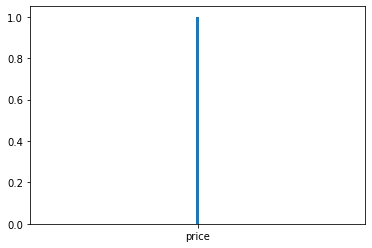

In [81]:
# Histogram of residuals

plt.hist(resids, bins=bins);

In [82]:
print(resids.max())
resids.min()

price   5.43
dtype: float64


price   -0.39
dtype: float64

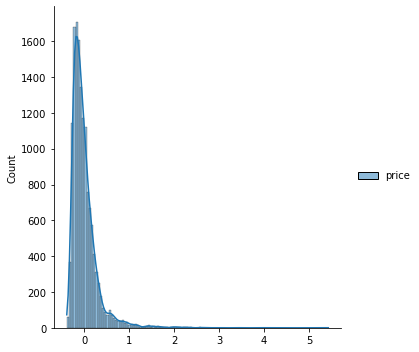

In [83]:
sns.displot(resids, bins=bins, kde=True)

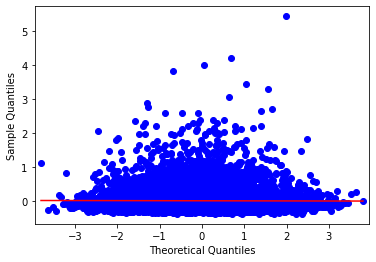

In [84]:
sm.qqplot(resids, line='r');

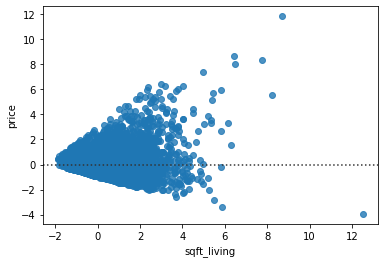

In [85]:
# resid plot sns.resid

sns.residplot(x=X, y=y);

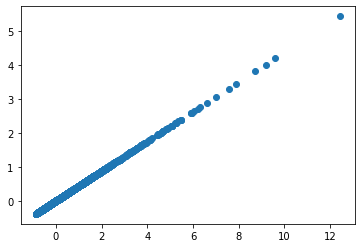

In [86]:
plt.scatter(preds, resids);

In [87]:
#Fit the dummy_regressor

dummy_lr.fit(X_s_p,y_s_p)

DummyRegressor()

In [88]:
# Score it

dummy_lr.score(X_s_p,y_s_p)

0.0

In [89]:
# Creating a straightforward, initial model --
# just for kicks
simple_formula = 'price ~ sqft_living'
simple_model = ols(formula = simple_formula,
                   data = scaled_and_parse_df).fit()
simple_mod_summ = simple_model.summary()

simple_mod_summ

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.485
Model:                            OLS   Adj. R-squared:                  0.485
Method:                 Least Squares   F-statistic:                 1.346e+04
Date:                Wed, 30 Mar 2022   Prob (F-statistic):               0.00
Time:                        16:23:18   Log-Likelihood:                -15558.
No. Observations:               14309   AIC:                         3.112e+04
Df Residuals:                   14307   BIC:                         3.114e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept   -1.017e-16      0.006   -1.7e-14      1.000      -0.012       0.012
sqft_living     0.6963      0.006    116.035      0.000       0.685       0.708
==============================================================================
Omnibus:                     9226.498   Durbin-Watson:                   2.002
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           257916.983
Skew:                           2.659   Prob(JB):                         0.00
Kurtosis:                      23.107   Cond. No.                         1.00
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [90]:
#test on our test data set

Summary comparison between the two

#### Multiple regression | Rework to train data

Slowly adding in other variables

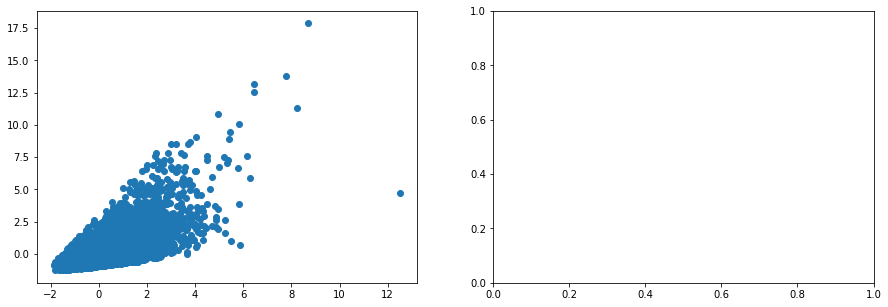

In [91]:
fig, ax = plt.subplots(ncols=2,figsize=(15,5))

x1 = scaled_and_parse_df[['sqft_living']]
y1 = scaled_and_parse_df[['price']]

# x2 = scaled_and_parse_df[['bedrooms']]

ax[0].scatter(x1, y1)
# ax[1].scatter(x2,y1);

#Upon looking at our scaled dataframe, we noticed that there is a house sold with 33 bedrooms for $600k
#After considering the price sold, sqft and number of bathrooms - the # of bedrooms appears 
#to be an error of somesort
#Since we explored bedrooms having a relatively small correlation to price, we are not too worried about this one
#outlier being included in our scatterplot

In [92]:
simple_formula3 = 'price ~ sqft_living'
simple_model3 = ols(formula = simple_formula3,
                   data = scaled_and_parse_df).fit()
simple_mod_summ3 = simple_model3.summary()

simple_mod_summ3

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.485
Model:                            OLS   Adj. R-squared:                  0.485
Method:                 Least Squares   F-statistic:                 1.346e+04
Date:                Wed, 30 Mar 2022   Prob (F-statistic):               0.00
Time:                        16:23:19   Log-Likelihood:                -15558.
No. Observations:               14309   AIC:                         3.112e+04
Df Residuals:                   14307   BIC:                         3.114e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept   -1.017e-16      0.006   -1.7e-14      1.000      -0.012       0.012
sqft_living     0.6963      0.006    116.035      0.000       0.685       0.708
==============================================================================
Omnibus:                     9226.498   Durbin-Watson:                   2.002
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           257916.983
Skew:                           2.659   Prob(JB):                         0.00
Kurtosis:                      23.107   Cond. No.                         1.00
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [93]:
scaled_and_parse_df.head()

,bedrooms,bathrooms,sqft_living,sqft_lot,yr_built,zipcode,price,grade_11_Excellent,grade_12_Luxury,grade_13_Mansion,grade_4_Low,grade_5_Fair,grade_6_Low_Average,grade_7_Average,grade_8_Good,grade_9_Better,view_FAIR,view_GOOD,view_NONE
1215,5,3.25,2.21,7920,1921,98122,3.67,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,1.00,0.00
12590,3,1.75,-0.29,7194,1967,98003,-0.86,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,1.00
13720,3,1.75,-0.99,4000,1929,98118,-0.56,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,1.00
15200,3,1.00,-1.11,6164,1967,98001,-1.01,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,1.00
10730,4,2.50,0.74,13093,1989,98075,0.56,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,1.00


In [94]:
simple_formula4 = 'price ~ sqft_living + view_FAIR + view_GOOD +view_NONE + grade_11_Excellent + grade_12_Luxury + grade_13_Mansion + grade_4_Low + grade_5_Fair + grade_6_Low_Average + grade_7_Average + grade_8_Good+ grade_9_Better'          

simple_model4 = ols(formula = simple_formula4,
                   data = scaled_and_parse_df).fit()

simple_mod_summ4 = simple_model4.summary()

simple_mod_summ4

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.613
Model:                            OLS   Adj. R-squared:                  0.613
Method:                 Least Squares   F-statistic:                     1741.
Date:                Wed, 30 Mar 2022   Prob (F-statistic):               0.00
Time:                        16:23:19   Log-Likelihood:                -13514.
No. Observations:               14309   AIC:                         2.706e+04
Df Residuals:                   14295   BIC:                         2.716e+04
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept               2.2036      0.050     43.654      0.000       2.105       2.303
sqft_living             0.3507      0.008     42.550      0.000       0.335       0.367
view_FAIR              -1.1252      0.049    -22.966      0.000      -1.221      -1.029
view_GOOD              -0.9717      0.056    -17.492      0.000      -1.081      -0.863
view_NONE              -1.4872      0.045    -32.973      0.000      -1.576      -1.399
grade_11_Excellent      0.7548      0.045     16.852      0.000       0.667       0.843
grade_12_Luxury         2.1826      0.085     25.579      0.000       2.015       2.350
grade_13_Mansion        5.0714      0.281     18.049      0.000       4.521       5.622
grade_4_Low            -1.1978      0.151     -7.952      0.000      -1.493      -0.903
grade_5_Fair           -1.1330      0.061    -18.613      0.000      -1.252      -1.014
grade_6_Low_Average    -1.0490      0.035    -29.825      0.000      -1.118      -0.980
grade_7_Average        -0.9660      0.029    -33.382      0.000      -1.023      -0.909
grade_8_Good           -0.8082      0.027    -29.666      0.000      -0.862      -0.755
grade_9_Better         -0.4747      0.028    -17.178      0.000      -0.529      -0.421
==============================================================================
Omnibus:                     8658.642   Durbin-Watson:                   2.009
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           350585.128
Skew:                           2.297   Prob(JB):                         0.00
Kurtosis:                      26.810   Cond. No.                         79.2
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

The above model has an adjusted R-squared value of 0.623 suggesting that this model accounts for roughly ~10-15% more variance.

In [95]:
simple_formula4 = 'price ~ view_FAIR + view_GOOD +view_NONE + grade_11_Excellent + grade_12_Luxury + grade_13_Mansion + grade_4_Low + grade_5_Fair + grade_6_Low_Average + grade_7_Average + grade_8_Good+ grade_9_Better'          

simple_model4 = ols(formula = simple_formula4,
                   data = scaled_and_parse_df).fit()

simple_mod_summ4 = simple_model4.summary()

simple_mod_summ4

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.564
Model:                            OLS   Adj. R-squared:                  0.563
Method:                 Least Squares   F-statistic:                     1540.
Date:                Wed, 30 Mar 2022   Prob (F-statistic):               0.00
Time:                        16:23:19   Log-Likelihood:                -14367.
No. Observations:               14309   AIC:                         2.876e+04
Df Residuals:                   14296   BIC:                         2.886e+04
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept               2.8781      0.051     56.582      0.000       2.778       2.978
view_FAIR              -1.1857      0.052    -22.810      0.000      -1.288      -1.084
view_GOOD              -1.0073      0.059    -17.086      0.000      -1.123      -0.892
view_NONE              -1.6395      0.048    -34.357      0.000      -1.733      -1.546
grade_11_Excellent      1.0632      0.047     22.661      0.000       0.971       1.155
grade_12_Luxury         2.9069      0.089     32.754      0.000       2.733       3.081
grade_13_Mansion        6.3303      0.297     21.345      0.000       5.749       6.912
grade_4_Low            -2.2749      0.158    -14.436      0.000      -2.584      -1.966
grade_5_Fair           -2.0836      0.060    -34.669      0.000      -2.201      -1.966
grade_6_Low_Average    -1.9208      0.030    -63.305      0.000      -1.980      -1.861
grade_7_Average        -1.6445      0.026    -64.165      0.000      -1.695      -1.594
grade_8_Good           -1.3021      0.026    -49.773      0.000      -1.353      -1.251
grade_9_Better         -0.7164      0.029    -24.957      0.000      -0.773      -0.660
==============================================================================
Omnibus:                    10003.767   Durbin-Watson:                   2.015
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           592087.179
Skew:                           2.735   Prob(JB):                         0.00
Kurtosis:                      34.035   Cond. No.                         78.6
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [96]:
simple_formula4 = 'price ~ sqft_living + grade_11_Excellent + grade_12_Luxury + grade_13_Mansion + grade_4_Low + grade_5_Fair + grade_6_Low_Average + grade_7_Average + grade_8_Good+ grade_9_Better'          

simple_model4 = ols(formula = simple_formula4,
                   data = scaled_and_parse_df).fit()

simple_mod_summ4 = simple_model4.summary()

simple_mod_summ4

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.574
Model:                            OLS   Adj. R-squared:                  0.574
Method:                 Least Squares   F-statistic:                     1927.
Date:                Wed, 30 Mar 2022   Prob (F-statistic):               0.00
Time:                        16:23:20   Log-Likelihood:                -14198.
No. Observations:               14309   AIC:                         2.842e+04
Df Residuals:                   14298   BIC:                         2.850e+04
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept               0.8148      0.027     30.074      0.000       0.762       0.868
sqft_living             0.3899      0.009     45.552      0.000       0.373       0.407
grade_11_Excellent      0.8231      0.047     17.538      0.000       0.731       0.915
grade_12_Luxury         2.4982      0.089     28.116      0.000       2.324       2.672
grade_13_Mansion        5.0148      0.295     17.020      0.000       4.437       5.592
grade_4_Low            -1.1950      0.158     -7.565      0.000      -1.505      -0.885
grade_5_Fair           -1.1372      0.064    -17.812      0.000      -1.262      -1.012
grade_6_Low_Average    -1.0886      0.037    -29.524      0.000      -1.161      -1.016
grade_7_Average        -1.0244      0.030    -33.804      0.000      -1.084      -0.965
grade_8_Good           -0.8569      0.029    -30.029      0.000      -0.913      -0.801
grade_9_Better         -0.5067      0.029    -17.492      0.000      -0.564      -0.450
==============================================================================
Omnibus:                     9217.783   Durbin-Watson:                   2.005
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           332869.043
Skew:                           2.566   Prob(JB):                         0.00
Kurtosis:                      26.065   Cond. No.                         61.8
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [97]:
simple_formula4 = 'price ~ sqft_living + view_FAIR + view_GOOD + view_NONE'

simple_model4 = ols(formula=simple_formula4,
                    data=scaled_and_parse_df).fit()

simple_mod_summ4 = simple_model4.summary()

simple_mod_summ4

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.537
Model:                            OLS   Adj. R-squared:                  0.537
Method:                 Least Squares   F-statistic:                     4149.
Date:                Wed, 30 Mar 2022   Prob (F-statistic):               0.00
Time:                        16:23:20   Log-Likelihood:                -14793.
No. Observations:               14309   AIC:                         2.960e+04
Df Residuals:                   14304   BIC:                         2.963e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept       1.6623      0.048     34.406      0.000       1.568       1.757
sqft_living     0.6316      0.006    106.256      0.000       0.620       0.643
view_FAIR      -1.3355      0.053    -25.161      0.000      -1.440      -1.231
view_GOOD      -1.1213      0.060    -18.574      0.000      -1.240      -1.003
view_NONE      -1.7249      0.049    -35.358      0.000      -1.821      -1.629
==============================================================================
Omnibus:                     8549.060   Durbin-Watson:                   2.008
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           255622.423
Skew:                           2.353   Prob(JB):                         0.00
Kurtosis:                      23.164   Cond. No.                         23.6
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

It appears that our model is the strongest when we are comparing `sqft_living` + `view` + `grade` with an adjusted R-squared of 0.623.


## Next Steps:

- `bathrooms` and `bedrooms` - they are collinear with variables like `sqft_living`, which prevented us from including them in our model, but they might be useful avenues for further exploration.
- `waterfront` - our EDA demonstrated a significant difference in `price` between homes with waterfront views vs. homes without; it may be worth further exploring what development opportunities exist in waterfront areas.
- `zipcode` - taking a look at what neighborhoods/geographic areas yield high sale prices.
    - Look at interaction items: if homes with `EXCELLENT` views are concentrated in certain areas, perhaps.

# Unused Code

In [98]:
# Log transform `sqft_living` column
# df_copy['sqft_living'] = np.log(df_copy['sqft_living'])

In [99]:
# Scale `bathrooms` column on 0 to 1 min-max
# mms = MinMaxScaler()
# df_copy[['bathrooms']] = mms.fit_transform(df_copy[['bathrooms']])